# ガウス混合モデル

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [3]:
from sklearn.datasets.samples_generator import make_blobs

In [4]:
X, y_true = make_blobs(n_samples=400, centers=4,
                                           cluster_std=0.60, random_state=0)
X = X[:, ::-1]

In [5]:
from sklearn.cluster import KMeans

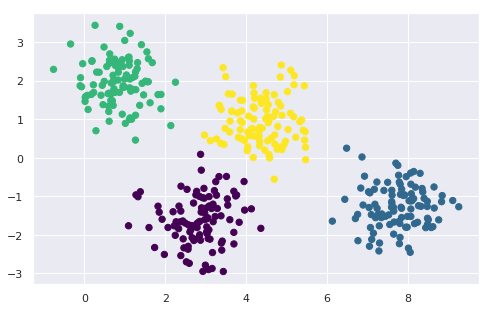

In [6]:
kmeans = KMeans(4, random_state=0)
labels =kmeans.fit(X).predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [7]:
from scipy.spatial.distance import cdist

In [8]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

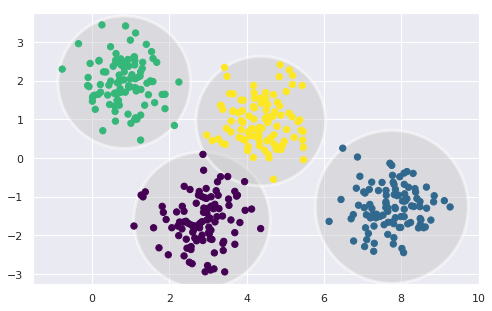

In [9]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

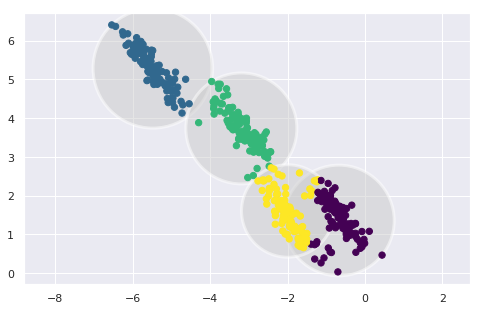

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

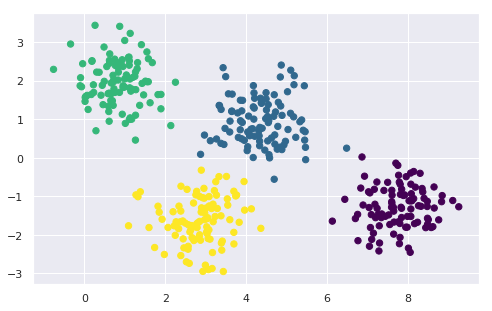

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [52]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


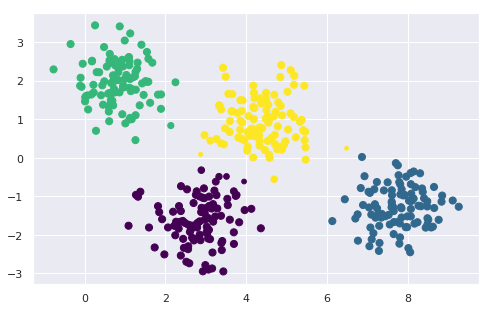

In [53]:
size = 50 * probs.max(1) ** 2
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap='viridis')

In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # 共分散を主軸に変換
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 楕円を描く
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize=(8, 5))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_ , gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

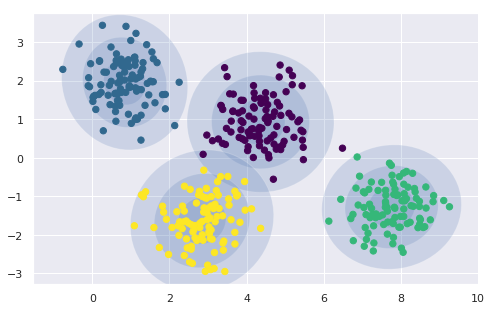

In [18]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

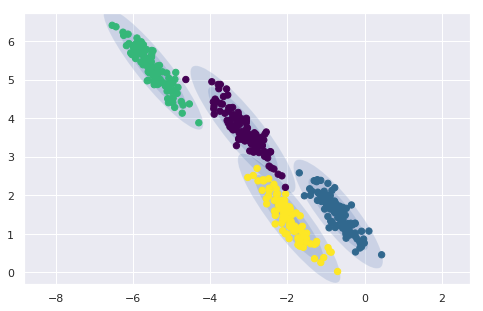

In [21]:
gmm = GaussianMixture(n_components=4, covariance_type='full',random_state=42)
plot_gmm(gmm, X_stretched)

## GMMによる密度推定


In [31]:
from sklearn.datasets import make_moons

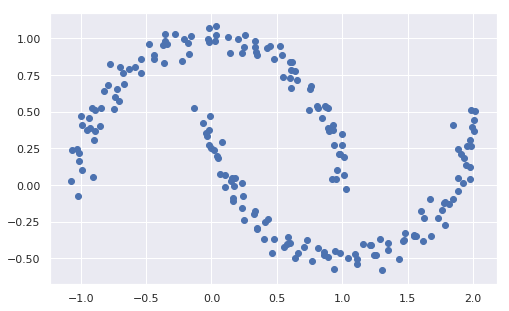

In [32]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.figure(figsize=(8, 5))
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

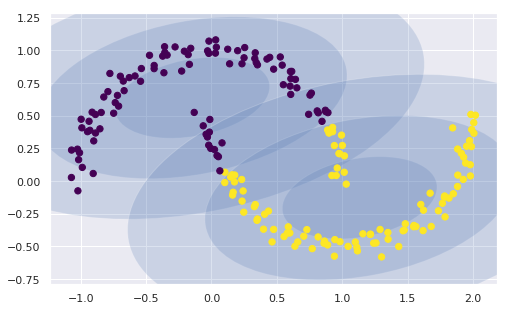

In [33]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full',random_state=0)
plot_gmm(gmm2, Xmoon)

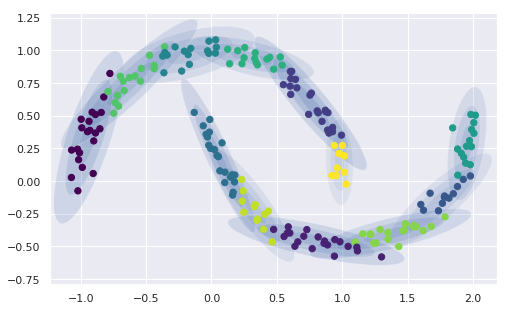

In [34]:
gmm16 = GaussianMixture(n_components=12, covariance_type='full',random_state=0)
plot_gmm(gmm16, Xmoon)

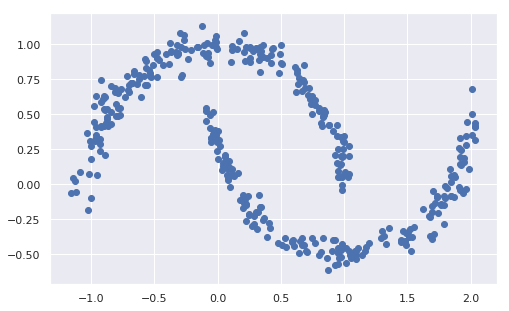

In [30]:
Xnew, _ = gmm16.sample(400)
plt.figure(figsize=(8, 5))

plt.scatter(Xnew[:, 0], Xnew[:, 1])

## 最適な成分数

In [35]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0, reg_covar=0.001).fit(Xmoon) for n in n_components]

Text(0.5, 0, 'n_components')

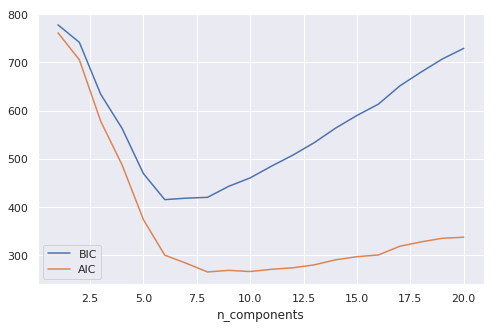

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend()
plt.xlabel('n_components')

クラスタの最適な数はAICかBICを最小にする値なので、今回の場合はクラスタ数が8~12くらいが良い

## 事例:GMMによるデータの生成

In [39]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [40]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10,  figsize=(8, 8),
                                          subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

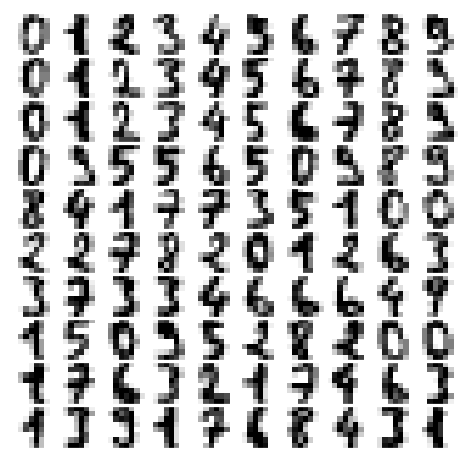

In [41]:
plot_digits(digits.data)

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

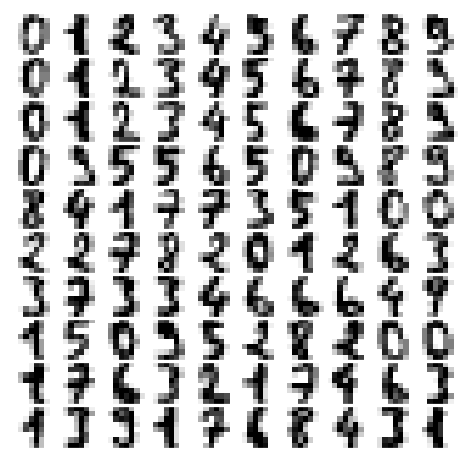

In [44]:
plot_digits(digits.data)

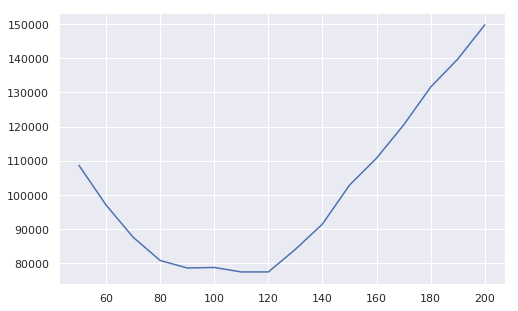

In [46]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0, reg_covar=0.001).fit(Xmoon) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]

plt.figure(figsize=(8, 5))
plt.plot(n_components, aics)

110くらいが良さそう

In [47]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [48]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

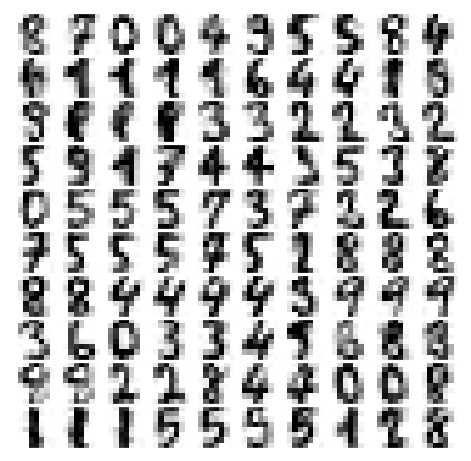

In [49]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)